# Feature Selection

* Keep 욕설
* Delete one letter words (No meaning)
* Delete 생소한 words
* Keep Noun, Adjective, Verb, KoreanParticles
* Information Gain

In [1]:
import pandas as pd
import csv
import os
from collections import defaultdict

In [2]:
allassult = []
with open('./dataset/assult.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        word = False
        for ch in row[0]:
            try:
                ch.encode('ascii')
                word = True
            except:
                pass
        if not word:
            allassult.append(row[0])

In [3]:
with open('./dataset/assult2.csv','w',newline='\n',encoding='utf-8') as writefile:
    writer = csv.writer(writefile)
    for assult in allassult:
        writer.writerow([assult])

## 모든 단어 set 확인 및 욕설 단어 갯수 확인

* 욕 DB에 있는 1439개 단어 중 506개가 사용됨

In [4]:
allword = set()

In [5]:
filepath = './cbt5_onlyoneday_result/'
files = os.listdir(filepath)
for file in files:
    with open(filepath+file,'r',encoding='utf-8') as readfile:
        reader = csv.reader(readfile)
        for row in reader:
            allword.add(row[0])

In [6]:
len(allword)

69551

In [7]:
assult_set = set(allassult)
len(assult_set)

1439

In [8]:
len(allword & assult_set)

343

---

## 한글자 짜리, 형태소 의미 없는 것들 삭제 + 욕 db에 있으면 남기기

* Noun, Verb, Adjective, KoreanParticle 만 남기기
* 1글자 짜리 삭제

In [9]:
filepath = './cbt5_onlyoneday_result/'
files = os.listdir(filepath)
all_result = defaultdict(lambda:"")
for file in files:
    with open(filepath+file,'r',encoding='utf-8') as readfile:
        reader = csv.reader(readfile)
        game_id = int(file.split('.')[0])
        for row in reader:
            pos = row[1]
            if row[0] in assult_set:
                for i in range(0,int(row[2])):
                    all_result[game_id]+=(row[0]+" ")
            elif pos in (["Noun","Verb","Adjective","KoreanParticle"]):
                if len(row[0])>1:
                    for i in range(0,int(row[2])):
                        all_result[game_id]+=(row[0]+" ")


라벨링 후 저장

In [10]:
a_list = []
f_list = []
with open('./dataset/cbt5_label.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        if row[1]=='A':
            a_list.append(int(row[0]))
        else:
            f_list.append(int(row[0]))

In [11]:
allword = set()

In [39]:
with open('./dataset/cbt5_oneday_label.csv','w',newline='\n',encoding='utf-8') as writefile:
    writer = csv.writer(writefile)
    writer.writerow(['game_id','corpus','label'])
    for game_id in all_result.keys():

        if game_id in a_list:
            for w in all_result[game_id].split(' '):
                allword.add(w)
            writer.writerow([game_id,all_result[game_id],'a'])
        elif game_id in f_list:
            writer.writerow([game_id,all_result[game_id],'f'])
            for w in all_result[game_id].split(' '):
                allword.add(w)

In [13]:
len(allword)

30431

# Make Bow

In [22]:
data = pd.read_csv('./dataset/cbt5_threeday_label.csv')
data.head()

,game_id,corpus,label
0,10014,심해서 그럼 그럼 그럼 최저 가서 ㄴㅇㅣ 언제 언제 마을 마을 최솔 사랑해 수고해 ...,f
1,10037,문제 나와라 ㅅㅂ ㅅㅂ ㅅㅂ 들리는 들리는 방가 소리 소리 소리 소리 가는 들리 들...,f
2,10185,이름 하시 ㅋㅋ ㅋㅋ ㅋㅋ ㅋㅋ ㅋㅋ ㅋㅋ 해주시 해주시 해주시 해주시 해주시 해주...,a
3,10230,쩐다 쩐다 쩐다 초반 초반 도하 적용된 죽자 있다 신고하면 그게 시간 시간 차클베떄...,f
4,10231,지지 쾨적 채팅 줄어 어디 아키 아키 공지 달라 멋지 풀옵 풀옵 갑자기 사람 확인 ...,f


In [23]:
data.groupby(['label']).size().reset_index(name='counts')

,label,counts
0,a,438
1,f,521


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
def make_review_bow(data):    
   
    vectorizer = CountVectorizer(min_df=0)

    doc = []
    
    for text in data['corpus']:
        doc.append(text)
    vectorizer.fit(doc)
    x = vectorizer.transform(doc)
    bow2 = x.toarray()
    bow = pd.DataFrame(bow2,columns=vectorizer.vocabulary_.keys())

    return vectorizer, bow

In [26]:
vectorizer, X = make_review_bow(data)
Y = data['label']

In [27]:
over_col = []
for col in X.columns:
    if (X[col].sum())>=10:
        over_col.append(col)

In [28]:
X_2 = X[over_col]

In [29]:
# X_2['game_id']=data['game_id']
X_2.shape

(959, 7280)

In [30]:
# X_2.to_csv('./oneday_vector.csv',encoding='utf-8',index=False)

In [35]:
(71.69+84.19+79.04)/3

78.30666666666667

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(X_2,Y,test_size=0.3)

In [32]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))
print (cm)
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))
print (cm)
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * lg.score(x_test, y_test))
x_test['lr'] = y_pred
print (cm)

Model Accuracy: 86.1111111111
[[118  17]
 [ 23 130]]
Model Accuracy: 87.5
[[125  10]
 [ 26 127]]
Model Accuracy: 84.0277777778
[[104  31]
 [ 15 138]]


C:\Users\ahroobe\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
x_test['real'] = y_test

C:\Users\ahroobe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
x_test.to_csv('./lr_result.csv',index=False, encoding='utf-8')

In [56]:
import operator

In [51]:
tp = x_test[(x_test['lr']=='a') & ( x_test['real']=='a')]
fp = x_test[(x_test['lr']=='a') & ( x_test['real']=='f')]
fn = x_test[(x_test['lr']=='f') & ( x_test['real']=='a')]
tn = x_test[(x_test['lr']=='f') & ( x_test['real']=='f')]

In [60]:
tp.head()

,쩐다,좀덜,초반,가나,도하,그렇,개그,적용된,표시,죽자,...,읗나흐,폭눈,부관,챤트,마링,긿잃자,낄껀데,헥있음,lr,real
740,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,a,a
120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,a,a
261,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,a,a
379,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,a,a
238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,a,a


In [69]:
word_count =dict()
for col in tp.columns[:-2]:
    word_count[col] = tp[col].astype(bool).sum()

In [70]:
sorted_x = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)

In [71]:
sorted_x

[('가더', 41),
 ('비유왕', 36),
 ('어쩌다가', 32),
 ('동훈', 32),
 ('속하는', 31),
 ('책임', 31),
 ('관장', 30),
 ('기대', 29),
 ('달려갈', 29),
 ('편지지', 29),
 ('히이이잉', 28),
 ('모집합', 27),
 ('시끄럽', 27),
 ('두르', 27),
 ('알꺠드려', 27),
 ('웁니', 27),
 ('쌓였', 26),
 ('견해', 26),
 ('대론', 25),
 ('줄라', 25),
 ('일로일로', 25),
 ('쎄쎼쎄하면', 25),
 ('동일하게', 25),
 ('도안', 24),
 ('김치', 24),
 ('ㅣㅓㅁㄴ', 24),
 ('벗냐', 24),
 ('정직', 24),
 ('대효', 23),
 ('ㅘㄴ', 23),
 ('피똥', 23),
 ('달무리', 23),
 ('분거', 22),
 ('빈칸', 22),
 ('쩐다', 21),
 ('잭스', 21),
 ('나올삘', 21),
 ('아나팅', 20),
 ('루셔', 20),
 ('타게팅', 20),
 ('통하는', 20),
 ('몹좀', 20),
 ('래버어디갓', 19),
 ('져깄', 19),
 ('ㅈㅋㅈㅋㅋ', 19),
 ('이상', 18),
 ('모습', 18),
 ('해설', 18),
 ('말임', 18),
 ('혁신', 18),
 ('요하른', 18),
 ('의별', 17),
 ('자유형', 17),
 ('주머니', 17),
 ('공개', 17),
 ('대루', 17),
 ('다하냐', 17),
 ('설거지', 17),
 ('글쌔', 17),
 ('도번', 17),
 ('렙탬', 16),
 ('오셧음', 16),
 ('시볼롬', 16),
 ('총대', 16),
 ('옆방', 16),
 ('아파', 15),
 ('장소', 15),
 ('일일이', 15),
 ('단축', 15),
 ('매달리', 15),
 ('대문자', 15),
 ('데려갈', 15),
 ('정적', 15),
 ('알아봐',

In [72]:
word_count =dict()
for col in tp.columns[:-2]:
    word_count[col] = fp[col].astype(bool).sum()
sorted_x = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
sorted_x

[('가더', 28),
 ('쌓였', 23),
 ('어쩌다가', 23),
 ('도안', 22),
 ('동일하게', 21),
 ('비유왕', 20),
 ('달려갈', 20),
 ('관장', 20),
 ('두르', 19),
 ('동훈', 19),
 ('대효', 17),
 ('속하는', 17),
 ('책임', 17),
 ('시끄럽', 16),
 ('웁니', 16),
 ('기대', 15),
 ('모집합', 15),
 ('대론', 15),
 ('줄라', 15),
 ('편지지', 15),
 ('래버어디갓', 14),
 ('져깄', 14),
 ('ㅘㄴ', 14),
 ('히이이잉', 14),
 ('빈칸', 14),
 ('곱창', 14),
 ('달무리', 14),
 ('말임', 14),
 ('하란', 13),
 ('김치', 13),
 ('ㅣㅓㅁㄴ', 13),
 ('벗냐', 13),
 ('어워드', 13),
 ('ㅈㅋㅈㅋㅋ', 13),
 ('쎄쎼쎄하면', 13),
 ('서두', 13),
 ('이두', 13),
 ('아파', 12),
 ('장소', 12),
 ('루셔', 12),
 ('분거', 12),
 ('일로일로', 12),
 ('견해', 12),
 ('무릎', 11),
 ('타게팅', 11),
 ('대답해', 11),
 ('정직', 11),
 ('뛰어올', 11),
 ('알꺠드려', 11),
 ('몹좀', 11),
 ('ㅋㅋㄴㅔㅇ', 11),
 ('기상', 11),
 ('쩐다', 10),
 ('날아감', 10),
 ('일기', 10),
 ('정적', 10),
 ('구글링', 10),
 ('담달', 10),
 ('암사', 10),
 ('판형', 10),
 ('도때', 10),
 ('옆방', 10),
 ('자유형', 9),
 ('올라가는', 9),
 ('무기', 9),
 ('다완', 9),
 ('아르', 9),
 ('데려갈', 9),
 ('알아봐', 9),
 ('덩키', 9),
 ('스톰', 9),
 ('피똥', 9),
 ('기달령', 9),
 ('포인터', 9),
 ('총대'

In [73]:
word_count =dict()
for col in tp.columns[:-2]:
    word_count[col] = fn[col].astype(bool).sum()
sorted_x = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
sorted_x

[('가더', 27),
 ('속하는', 21),
 ('달려갈', 20),
 ('어쩌다가', 19),
 ('대효', 17),
 ('비유왕', 17),
 ('관장', 17),
 ('쌓였', 16),
 ('동훈', 16),
 ('서두', 16),
 ('동일하게', 16),
 ('기대', 15),
 ('다완', 15),
 ('시끄럽', 15),
 ('두르', 15),
 ('견해', 15),
 ('정직', 15),
 ('책임', 15),
 ('모집합', 14),
 ('대론', 14),
 ('루셔', 14),
 ('알꺠드려', 14),
 ('빈칸', 13),
 ('ㅈㅋㅈㅋㅋ', 13),
 ('달무리', 13),
 ('말임', 13),
 ('예전', 12),
 ('도안', 12),
 ('줄라', 12),
 ('벗냐', 12),
 ('담달', 12),
 ('총대', 12),
 ('웁니', 12),
 ('편지지', 12),
 ('말하기', 11),
 ('페관쪽', 11),
 ('나올삘', 11),
 ('져깄', 11),
 ('타게팅', 11),
 ('히이이잉', 11),
 ('통하는', 11),
 ('일로일로', 11),
 ('렙안되', 11),
 ('흐긴여케', 11),
 ('모습', 10),
 ('올라가는', 10),
 ('팟좀', 10),
 ('아르', 10),
 ('엇어', 10),
 ('대고', 10),
 ('오셧음', 10),
 ('일일이', 10),
 ('ㅣㅓㅁㄴ', 10),
 ('ㅘㄴ', 10),
 ('몹좀', 10),
 ('래버어디갓', 9),
 ('아파', 9),
 ('틀림', 9),
 ('공개', 9),
 ('잭스', 9),
 ('김치', 9),
 ('다하냐', 9),
 ('어워드', 9),
 ('글쌔', 9),
 ('이두', 9),
 ('요하른', 9),
 ('의별', 8),
 ('아나팅', 8),
 ('무릎', 8),
 ('뿌리', 8),
 ('단축', 8),
 ('아크라', 8),
 ('알람', 8),
 ('갠챠', 8),
 ('알아봐', 8),
 (

In [74]:
word_count =dict()
for col in tp.columns[:-2]:
    word_count[col] = tn[col].astype(bool).sum()
sorted_x = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
sorted_x

[('가더', 111),
 ('책임', 84),
 ('비유왕', 76),
 ('달려갈', 74),
 ('쌓였', 74),
 ('두르', 70),
 ('어쩌다가', 70),
 ('동훈', 67),
 ('다완', 58),
 ('동일하게', 57),
 ('줄라', 56),
 ('서두', 56),
 ('기대', 55),
 ('정직', 55),
 ('관장', 55),
 ('대효', 54),
 ('웁니', 53),
 ('속하는', 50),
 ('담달', 49),
 ('편지지', 49),
 ('시끄럽', 44),
 ('틀림', 44),
 ('빈칸', 43),
 ('ㅈㅋㅈㅋㅋ', 43),
 ('분거', 42),
 ('벗냐', 42),
 ('대론', 41),
 ('견해', 41),
 ('모습', 40),
 ('곱창', 40),
 ('도안', 39),
 ('져깄', 39),
 ('흐긴여케', 39),
 ('래버어디갓', 37),
 ('엇어', 37),
 ('총대', 37),
 ('알꺠드려', 37),
 ('아르', 36),
 ('정적', 36),
 ('알람', 36),
 ('히이이잉', 36),
 ('무릎', 35),
 ('어워드', 34),
 ('귓말주세요뿌잉', 34),
 ('장소', 33),
 ('루셔', 33),
 ('먈컴', 33),
 ('모집합', 32),
 ('말하기', 32),
 ('ㅣㅓㅁㄴ', 32),
 ('글쌔', 32),
 ('말임', 32),
 ('김치', 31),
 ('타게팅', 31),
 ('ㅘㄴ', 31),
 ('글쎼용', 30),
 ('락퀘', 30),
 ('아파', 28),
 ('팟좀', 28),
 ('잭스', 28),
 ('퀘못', 28),
 ('일로일로', 28),
 ('도번', 28),
 ('요하른', 28),
 ('무기', 27),
 ('툴팁', 27),
 ('나올삘', 27),
 ('피똥', 27),
 ('포인터', 27),
 ('이상', 26),
 ('아인', 26),
 ('단축', 26),
 ('태양', 26),
 ('쎄쎼쎄하면', 2

In [99]:
rank = defaultdict(lambda:0)
for i, col in enumerate(x_train.columns):
    rank[col] = lg.coef_[0][i]
sorted_rank = sorted(rank.items(), key=operator.itemgetter(1), reverse=True)

In [102]:
sorted_rank[:100]

[('다완', 0.33467301201478789),
 ('스톰', 0.29165096934548917),
 ('ㅇㅁㅇ', 0.28739023734930225),
 ('어오렉', 0.26132652073060353),
 ('렙에하', 0.25476444095215833),
 ('여태', 0.25329942323614907),
 ('다되셧어', 0.25200168155106945),
 ('ㅋㅋㄴㅔㅇ', 0.24731680984092602),
 ('버스', 0.24532989044459105),
 ('잭스', 0.24390535373767588),
 ('국산', 0.23959863333138712),
 ('말하세', 0.23764916472031283),
 ('쌓였', 0.23758200658783893),
 ('글쎼용', 0.23648960076143358),
 ('채우고', 0.22998704969893166),
 ('진자', 0.22622194139374613),
 ('어칼', 0.22354887962350461),
 ('귓말주세요뿌잉', 0.22317925475874478),
 ('채굴', 0.22311161333299714),
 ('머머석', 0.22251297547847099),
 ('모습', 0.2218035508613771),
 ('갠찬', 0.22090288915167),
 ('울트라', 0.22076065429236932),
 ('올라가는', 0.22044506387706272),
 ('약초', 0.21548255850318437),
 ('싱담', 0.2145023366859703),
 ('알꺠드려', 0.21188383239086847),
 ('좇같', 0.21044111004959759),
 ('님신', 0.19478412143689464),
 ('의별', 0.19264602850472187),
 ('오졋는뎅', 0.19154283292322574),
 ('대답하게', 0.19127052781536025),
 ('빼기', 0.188435014

In [105]:
sorted_rank[-100:]

[('이속', -0.15485028517426622),
 ('넉느데', -0.15493074521112413),
 ('필요합', -0.15494704766571321),
 ('ㅇㅈㅇ', -0.15504560929732589),
 ('크크흐콰한', -0.15552538625024429),
 ('ㅔㅔ', -0.15556035943323909),
 ('이쪽으루', -0.15559088637685181),
 ('조아할', -0.15643703163650705),
 ('꺼졍', -0.15732447239246655),
 ('오셧음', -0.15830312206948988),
 ('달려랏', -0.1584524041841901),
 ('ㅓㅂ', -0.15906661773185829),
 ('또찻어', -0.15982809585641322),
 ('빛나죠', -0.16000776982696349),
 ('인해', -0.16001734169878012),
 ('대론', -0.16028316438756623),
 ('하란', -0.16066181450703976),
 ('유지하고', -0.16153658229418535),
 ('졸다', -0.16242938117474945),
 ('햣도그', -0.1626024015706326),
 ('가소', -0.16289634278913603),
 ('온길', -0.16350651838010696),
 ('현상', -0.16495276349819513),
 ('보물', -0.16696554619983048),
 ('해설', -0.16715561173329171),
 ('병임', -0.16752098451798619),
 ('대통령', -0.16925230752869055),
 ('잠들었', -0.16925985345523903),
 ('조흐', -0.17063969072769805),
 ('뺴곤없음', -0.1708850095366056),
 ('화려한', -0.17130377209623857),
 ('안댕', -0.1735834409

## 10-fold cross-validation

In [53]:
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = SGDClassifier()
scores = cross_val_score(sgd, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

nb = MultinomialNB()
scores = cross_val_score(nb, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

lg = LogisticRegression()
scores = cross_val_score(lg, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

Average accuracy :  0.708025604552
Average accuracy :  0.733679468943
Average accuracy :  0.746747273589


---

# using first 3000 words

In [103]:
data = pd.read_csv('./dataset/cbt5_corpus3000label.csv')
data.head()

,game_id,corpus,label
0,1001,교훈 시기 시기 계신 계신 사태 놓치는 오래 오래 오래 오래 이상 아쉬운 해주시 사...,a
1,10014,인생 인생 만세 있다 같은 랩때 날틀 날틀 싶은 지랄 지랄 지랄 지랄 쉬발 먹엇어 ...,f
2,10037,문제 추자 춤좀 겜톡 겜톡 겜톡 겜톡 겜톡 안되는 셔플 셔플 셔플 쩐다 맨손 마리 ...,f
3,10185,하셧 가기 계신 보고 싶은 짜증 짜증 약간 육식 육식 육식 육식 육식 육식 육식 육...,a
4,10230,찾기 ㅇㅋㅇㅋ 나지 개사 잡으 여기 여기 여기 여기 여기 잠긴 업데이트 파티 좀덜 ...,f


In [104]:
vectorizer, X = make_review_bow(data)
Y = data.label
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [105]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))
print (cm)
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))
print (cm)
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * lg.score(x_test, y_test))
print (cm)


Model Accuracy: 95.5271565495
[[141   7]
 [  7 158]]
Model Accuracy: 92.3322683706
[[148   0]
 [ 24 141]]
Model Accuracy: 94.8881789137
[[138  10]
 [  6 159]]


In [106]:
X.head()

,교훈,시기,계신,사태,놓치는,오래,이상,아쉬운,해주시,사이좋,...,수익금,ㅣㅓ,은괴듬,빠빠밤,명있었꼬,나다물량,ㅇㄹㄴㅇㄹ,선창,리익,ㅜㄴㅁㅇㄹ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Cut TF below 10 words

In [19]:
words1 = pd.read_csv('./dataset/tfidf_more10_oneday_a.csv',encoding='cp949')
words2 = pd.read_csv('./dataset/tfidf_more10_oneday_f.csv',encoding='cp949')

In [20]:
words1.head()

,word,tf-idf,tf
0,다음,1.951173,122
1,ㅎㅎ,2.456763,427
2,어요,2.103304,178
3,이제,2.387735,360
4,높아,1.070046,13


In [21]:
words1 = set(words1.word)
words2 = set(words2.word)

In [22]:
words3 = set(X.columns)

In [23]:
word_list = list((words1 | words2)&words3)
len(word_list)

2578

In [31]:
X_2 = X[word_list]

In [29]:
X_2['label']= Y

In [33]:
X_2.shape

(750, 2578)

In [35]:
X_2['game_id'] = data['game_id']

C:\Users\ahroobe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
X_2.to_csv('./oneday_vector.csv',index=False,encoding='utf-8')

In [28]:
vectorizer, X_2 = make_review_bow(data)
Y = data.label
x_train, x_test, y_train, y_test = train_test_split(X_2,Y,test_size=0.3)

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))
print (cm)
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))
print (cm)
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * lg.score(x_test, y_test))
print (cm)


Model Accuracy: 75.1111111111
[[ 47  26]
 [ 30 122]]
Model Accuracy: 72.4444444444
[[69  4]
 [58 94]]
Model Accuracy: 76.8888888889
[[ 44  29]
 [ 23 129]]


In [64]:
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = SGDClassifier()
scores = cross_val_score(sgd, X_2,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

nb = MultinomialNB()
scores = cross_val_score(nb, X_2,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

lg = LogisticRegression()
scores = cross_val_score(lg, X_2,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

Average accuracy :  0.708308677098
Average accuracy :  0.733679468943
Average accuracy :  0.746747273589


---

In [217]:
import operator

rank_sort = sorted(rank.items(), key=operator.itemgetter(1))

In [225]:
rank_sort[:20]

[('왓엇음아까', -0.36933042326327981),
 ('기억나시', -0.34176148766888553),
 ('심느', -0.31787785184912193),
 ('눌려봐', -0.27992123920726042),
 ('병헌', -0.26798251061236678),
 ('터보', -0.25918237283512491),
 ('쾌꺠', -0.25301726881625997),
 ('장의', -0.25172750277346495),
 ('돈줘잉', -0.2435215772879305),
 ('졸업', -0.24350618711943248),
 ('엄청쎔', -0.23539267526125809),
 ('찍힘', -0.22778153586599842),
 ('볼라', -0.22520670883696897),
 ('딱퍼임', -0.2244750272072227),
 ('모비', -0.22178627735941833),
 ('글픽글픽', -0.21786441721969713),
 ('보름달', -0.2172650123431013),
 ('달라짐', -0.21646262323450363),
 ('적용되는', -0.21257769956464734),
 ('스릇', -0.20410323380442313)]

In [224]:
rank_sort[-20:]

[('추고', 0.18597711133291603),
 ('낱틀', 0.18689764221194111),
 ('파티뎀지', 0.18896183311681691),
 ('지드래곤', 0.1891742242860926),
 ('싸우기', 0.19100943939961793),
 ('삑살', 0.19147741704721877),
 ('추가될', 0.19155956169882885),
 ('커졋', 0.19768686082593032),
 ('쓰러지', 0.20005559928220376),
 ('우걱', 0.20040974095067463),
 ('개새키', 0.20883316357774068),
 ('빡시겟군', 0.21879219234630404),
 ('왜배', 0.22424717629138832),
 ('교배', 0.23596548369521914),
 ('춤추던', 0.24923783438684174),
 ('어찌하지', 0.26240823393672036),
 ('입어봤', 0.26858836119727553),
 ('맞추셔', 0.29592821668684083),
 ('와우', 0.30521484438232521),
 ('걸렷는데', 0.40676794264676119)]

In [99]:
from sklearn.feature_selection import mutual_info_classif
import operator

In [96]:
res = dict(zip(X.columns, mutual_info_classif(x_train, y_train, discrete_features=True)))

In [104]:
sorted_x = sorted(res.items(), key=operator.itemgetter(1),reverse=False)

---

# 욕설 카운트

In [106]:
len(allassult)

1480

In [108]:
with open('./dataset/cbt5_corpus3000label.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    next(reader)
#     writer.writerow(['game_id','corpus','label'])
    with open('./dataset/cbt5_assultstat.csv','w',newline='\n') as writefile:
        writer = csv.writer(writefile)
        writer.writerow(['game_id','label','count'])
        for row in reader:
            words = row[1].split(' ')
            count = 0
            for word in words:
                if word in allassult:
                    count+=1
            writer.writerow([row[0],row[2],count])

In [118]:
assult_data = pd.read_csv('./dataset/cbt5_assultstat.csv')
assult_data.head()

,game_id,label,count
0,1001,a,3
1,10014,f,7
2,10037,f,8
3,10185,a,1
4,10230,f,4


In [120]:
data_a = assult_data.loc[assult_data.label=='a']
data_f = assult_data.loc[assult_data.label=='f']

In [121]:
import matplotlib.pyplot as plt

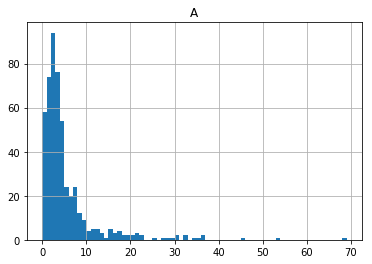

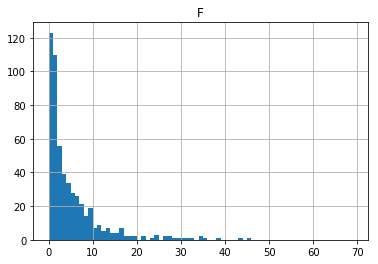

In [131]:

data_a['count'].hist(bins=range(0,70,1))
plt.title("A")
plt.show()

data_f['count'].hist(bins=range(0,70,1))
plt.title("F")
plt.show()

---
## Compare with other features. 

In [82]:
stat = pd.read_csv('./oneday_log.csv')

In [83]:
stat.head()

,game_id,comqu,crime,die,failq,frien,guild,harve,ind_i,level,soc_i
0,1002,0,0,0,0,0,0,0,1,7,0
1,1003,0,0,0,0,0,0,0,0,4,0
2,1006,0,0,0,0,0,0,0,0,3,0
3,1007,0,0,0,0,0,0,1,1,8,0
4,1008,0,0,0,0,0,0,0,0,8,0


In [84]:
labels =  pd.read_csv('./dataset/cbt5_oneday_label.csv')
labels.head()

,game_id,corpus,label
0,10230,쩐다 쩐다 쩐다 좀덜 초반 초반 가나 도하 그렇 개그 적용된 표시 죽자 신고하면 그...,f
1,10231,지지 줄어 쾨적하 갑자기 채팅 똒같 똒같 그래픽 그래픽 그래픽 불탄 불럿는데 진짜 ...,f
2,10346,다음 다음 멍떄렷네 비좀 어쩌구 편할 에이지 노딜하구 ㅎㅎ ㅎㅎ ㅎㅎ ㅎㅎ ㅎㅎ ㅎ...,a
3,10409,기억 보사 활쏘기 가요 당시 누가 저기 페레임 마굿 즉시 호랑이 지금 지금 지금 지...,a
4,10410,깻으 스킬 스킬 짜증 법사 법사 이런 졸려 거기 으콰봐 끈킴 끈킴 끈킴 있어 체력 ...,f


In [97]:
newdata = labels.set_index('game_id').join(stat.set_index('game_id'))

In [98]:
del newdata['corpus']

In [99]:
newdata.head()

,label,comqu,crime,die,failq,frien,guild,harve,ind_i,level,soc_i
game_id,,,,,,,,,,,
10230,f,60,0,12,0,0,0,22,0,5,0
10231,f,51,0,5,0,0,0,18,0,6,0
10346,a,188,0,36,0,0,0,118,0,8,0
10409,a,166,0,17,0,0,0,175,0,12,0
10410,f,106,0,11,0,0,0,39,0,4,0


In [100]:
X = newdata[newdata.columns[1:]]
Y = newdata['label']

In [89]:
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = SGDClassifier()
scores = cross_val_score(sgd, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

nb = MultinomialNB()
scores = cross_val_score(nb, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

lg = LogisticRegression()
scores = cross_val_score(lg, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

Average accuracy :  0.635863916548
Average accuracy :  0.753324324324
Average accuracy :  0.829487434803


## Integrate

In [114]:
X = X.set_index('game_id')

In [115]:
stat = pd.read_csv('./oneday_log.csv')
stat = stat.set_index('game_id')

In [116]:
newdata = X.join(stat)

In [119]:
X = newdata[newdata.columns[1:]]
Y = data['label']

sgd = SGDClassifier()
scores = cross_val_score(sgd, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

nb = MultinomialNB()
scores = cross_val_score(nb, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

lg = LogisticRegression()
scores = cross_val_score(lg, X,Y, cv=10)
print ("Average accuracy : ",np.average(scores))

Average accuracy :  0.696165007112
Average accuracy :  0.724168326221
Average accuracy :  0.784135609294


In [37]:
(69.61+72.42+78.41)/3

73.48